# Pure fluid calculations with SAFT-$\gamma$-Mie

In this notebook, the available calculations with ```saftgammamie``` EoS for pure fluid are illustrated.

First, all the needed modules are imported.

- numpy: numerical interface and work with arrays
- pandas: to read a file with experimental information
- matplotlib: to plot results
- sgtpy: package with SAFT-$\gamma$-Mie EoS.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sgtpy import component, saftgammamie

Now, a pure component is configured and created with the ```component``` function. Then, the interaction parameters are set up with the ```component.saftgammamie``` method. Finally, the ```eos``` object is created with the ```saftgammamie``` function.

The ```eos``` object includes all the necessary methods to compute phase equilibria and interfacial properties using SAFT-$\gamma$-Mie EoS.

For this notebook, all calculations are exemplified for pure water.

In [2]:
water = component(GC={'H2O':1})
water.saftgammamie()
eos = saftgammamie(water)

When you run ``saftgammamie(component)``, SGTPy will attempt to compute the critical point of the fluid. If the procedure is successful you can check the computed values with the ``eos.Tc``, ``eos.Pc`` and ``eos.rhoc`` attributes. The bool ``eos.critical`` indicates if the computation was successful. 

In [3]:
print('Critical point calculation success: ', eos.critical)
if eos.critical:
    print('Critical temperature:', eos.Tc, 'K')
    print('Critical pressure:', eos.Pc, 'Pa')
    print('Critical density:', eos.rhoc, 'mol/m^3')

Critical point calculation success:  True
Critical temperature: 674.0027393857537 K
Critical pressure: 29432042.0044269 Pa
Critical density: 19696.845401275605 mol/m^3


If the critical point calculation is not successful, you can try computing the critical point of the fluid using the ``eos.get_critical`` method. The method returns the critical temperature [K], critical pressure [Pa], and critical density [mol/m^3]. You can supply better initial values to start the non-linear solver.

If you set the parameter ``overwrite=True``, the results from this method will overwrite the previous computed critical point at initialization.

In [4]:
# get_critical providing initial guesses
Tc0 = 670.  # K
rhoc0 = 19500.  # mol/m3

eos.get_critical(Tc0, rhoc0, full_output=False, overwrite=True)

(674.0027394180357, 29432042.01459343, 19696.87873848204)

You can compute pure bulk phase density (mol/m$^3$) at a given temperature (K) and pressure (Pa) using the ```eos.density``` method. If no initial guess is provided, the root volume is computed using Topliss's method.

You can compute roots for liquid (```'L'```) and vapor (```'V'```) phases.

In [5]:
# density for liquid phase
T = 373.  # K
P = 1e5  # Pa
rhol = eos.density(T, P, 'L')
rhol  # mol / m3

52766.66795892927

If a good guess is available for the density root, you can supply it, and then Newton's method is used to compute the root. This is **faster** than using Topliss's method.

In [6]:
# solving density root unsing Newton's method.
T = 373.  # K
P = 1e5  # Pa
rhol = eos.density(T, P, 'L', rho0=0.95*rhol)
rhol  # mol / m3

52766.66795893085

You can verify that the root is computed correctly with the ```eos.pressure``` method. This method computes the pressure (Pa) at a given density (mol/m$^3$) and temperature (K).

In [7]:
# computed pressure in Pa
eos.pressure(rhol, T)

100000.00001507603

You can compute saturation points at given pressure or temperature using the ```eos.tsat``` or ```eos.psat``` methods, respectively.

In each case you need to provide an initial guess for the unknown variable (temperature or pressure) and the method will return the computed variable and the liquid and vapor volume root at the given conditions.

In [8]:
# solving saturation pressure at given temperature
T = 373.  # K
P0 = 1e5  # Pa
Psat, vlsat, vvsat = eos.psat(T, P0=P0)
# Saturation Pressure (Pa), saturated liquid volume (m3/mol), saturated vapor volume (m3/mol).
Psat, vlsat, vvsat

(99083.56784635808, 1.895136425319926e-05, 0.030225138288276387)

In [9]:
# solving saturation temperature at given temperature
P = 1e5  # Pa
T0= 373.  # K
Tsat, vlsat, vvsat = eos.tsat(P, T0=T0)
# Saturation temperature (K), saturated liquid volume (m3/mol), saturated vapor volume (m3/mol).
Tsat, vlsat, vvsat

(373.2580391239163, 1.8955246628575097e-05, 0.029963767561002545)

Alternatively, if you don't supply an initial guess for the pressure and the critical point of the fluid was correctly computed at initialization, the pressure will be automatically initiated using the [zero-pressure o Pmin/Pmax algorithm](https://www.sciencedirect.com/science/article/pii/S0098135497000161). 

In [10]:
# computing VLE without initial guess
# equilibrium pressure (Pa), liquid volume (m3/mol), vapor volume (m3/mol)
eos.psat(T)

(99083.56784635386, 1.895136425319885e-05, 0.03022513825658582)

You also can compute thermal derived properties, such as residual Entropy (```eos.EntropyR```), residual Enthalpy (```eos.EnthalyR```), residual isochoric and isobaric heat capacities (```eos.CvR``` and ```eos.CpR```).

Furthermore, you can compute the speed of sound using the ```eos.speed_sound``` method. You will be required to supply the ideal gas contribution for the heat capacities at the given temperature (These can be obtained from DIPPR 801 database).

In [11]:
# computing residual enthalpy for computed saturated phases
Sl = eos.EntropyR(Tsat, P, 'L', v0=vlsat)
Sv = eos.EntropyR(Tsat, P, 'V', v0=vvsat)
# Vaporization entropy in J / mol K
Svap = Sv - Sl
Svap

106.75812667676611

In [12]:
# computing residual enthalpy for computed saturated phases
Hl = eos.EnthalpyR(Tsat, P, 'L', v0=vlsat)
Hv = eos.EnthalpyR(Tsat, P, 'V', v0=vvsat)
# Vaporization enthalpy in J / mol
Hvap = Hv - Hl
Hvap

39848.32902391236

In [13]:
# computing residual heat capacities of saturated liquid phase
rholsat = 1/vlsat
Cvrl = eos.CvR(rholsat, Tsat)
Cprl = eos.CpR(Tsat, P, 'L', v0=vlsat)
# residual isochoric and isobaric heat capacities in J / mol K
Cvrl, Cprl

(34.017871824022976, 37.58556227340037)

In [14]:
# Ideal gas heat capacities from DIPPR 801
R = 8.314

k1 = 33363
k2 = 26790
k3 = 2610.5
k4 = 8896
k5 = 1169

CpId = k1 + k2 * ((k3/Tsat) /np.sinh(k3/Tsat))**2
CpId += k4 * ((k5/Tsat) /np.cosh(k5/Tsat))**2
CpId /= 1000.  # J/mol K

CvId = CpId - R  # J/ mol K

# speed of sound from computed saturated phases in m/s
ul = eos.speed_sound(Tsat, P, 'L', v0=vlsat, CvId=CvId, CpId=CpId)
uv = eos.speed_sound(Tsat, P, 'V', v0=vvsat, CvId=CvId, CpId=CpId)
ul, uv

(1829.5322167918005, 464.53102213280545)

## Performance of the EoS against experimental data

The results of the EoS can be compared against experimental data obtained from NIST.

Similarly, as in SGTPy, you can also fit influence parameters for Square Gradient Theory. In order to do that you have to use the ```fit_cii``` function. Then, you can compute the interfacial tension using the ```sgt_pure``` function.

In [15]:
from sgtpy.sgt import sgt_pure
from sgtpy.fit import fit_cii

# comparing results from the EoS against data from NIST.
Tsat = np.array([300., 310., 320., 330., 340., 350., 360., 370., 380., 390., 400.])  # K
Psat = np.array([3536.8, 6231.1, 10546., 17213., 27188., 41682., 62194., 90535., 128850., 179640., 245770.]) # Pa
rhol = np.array([55315., 55139., 54919., 54662., 54371., 54049., 53698., 53321., 52918., 52490., 52038.])  # mol/m3
rhov = np.array([1.4204, 2.4237, 3.9778, 6.3042, 9.6808, 14.448, 21.014, 29.859, 41.537, 56.683, 76.014])  # mol/m3
speed_liq = np.array([1501.4, 1523.2, 1538.7, 1548.7, 1553.9, 1554.8, 1552., 1545.8, 1536.5, 1524.3, 1509.5]) # m/s
speed_vap = np.array([427.89, 434.63, 441.18, 447.54, 453.68, 459.58, 465.22, 470.57, 475.61, 480.32, 484.67])  # m/s
Hvap = np.array([43908.1, 43480. , 43048. , 42612.4, 42170.1, 41721.8, 41265.2, 40798.9, 40320.5, 39829.6, 39322.7])  # J/mol
iftexp = np.array([71.686, 70.106, 68.47 , 66.781, 65.04 , 63.248, 61.406, 59.517, 57.581, 55.601, 53.578]) # mN/m

# Ideal gas heat capacities from DIPPR 801
R = 8.314  # J / mol K

k1 = 33363
k2 = 26790
k3 = 2610.5
k4 = 8896
k5 = 1169
CpId = k1 + k2 * ((k3/Tsat) /np.sinh(k3/Tsat))**2
CpId += k4 * ((k5/Tsat) /np.cosh(k5/Tsat))**2
CpId /= 1000.  # J/mol K

CvId = CpId - R  # J/ mol K


# computing sautration properties: pressure, volumes, enthalpies and speed of sound.
P = np.zeros_like(Psat) 
vl = np.zeros_like(rhol)
vv = np.zeros_like(rhov)

ul = np.zeros_like(speed_liq)
uv = np.zeros_like(speed_vap)

Hls = np.zeros_like(Hvap)
Hvs = np.zeros_like(Hvap)

n= len(Psat)
i = 0 
P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])
ul[i] = eos.speed_sound(Tsat[i], P[i], 'L', v0=vl[i], CvId=CvId[i], CpId=CpId[i])
uv[i] = eos.speed_sound(Tsat[i], P[i], 'V', v0=vv[i], CvId=CvId[i], CpId=CpId[i])
Hls[i] = eos.EnthalpyR(Tsat[i], P[i], 'L', v0=vl[i])
Hvs[i] = eos.EnthalpyR(Tsat[i], P[i], 'V', v0=vv[i])

# following iterations can use already computed volume roots
for i in range(1, n):
    P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i], v0 = [vl[i-1], vv[i-1]])
    ul[i] = eos.speed_sound(Tsat[i], P[i], 'L', v0=vl[i], CvId=CvId[i], CpId=CpId[i])
    uv[i] = eos.speed_sound(Tsat[i], P[i], 'V', v0=vv[i], CvId=CvId[i], CpId=CpId[i])
    Hls[i] = eos.EnthalpyR(Tsat[i], P[i], 'L', v0=vl[i])
    Hvs[i] = eos.EnthalpyR(Tsat[i], P[i], 'V', v0=vv[i])

rhosaftl = 1/vl
rhosaftv = 1/vv

dHv = Hvs - Hls

# fitting influence parameters using experimental IFT and computed saturation info
cii = fit_cii(iftexp, Tsat, P, rhosaftl, rhosaftv, eos)
eos.cii = cii

ift = np.zeros_like(iftexp)
for i in range(n):
    ift[i] = sgt_pure(rhosaftv[i], rhosaftl[i], Tsat[i], Psat[i], eos)

c:\users\gusta\documents\sgtpy\sgtpy\sgt\sgtpure.py:64: RuntimeWarning: invalid value encountered in sqrt
  tenint = np.nan_to_num(np.sqrt(2*dOm))


The results are plotted below.

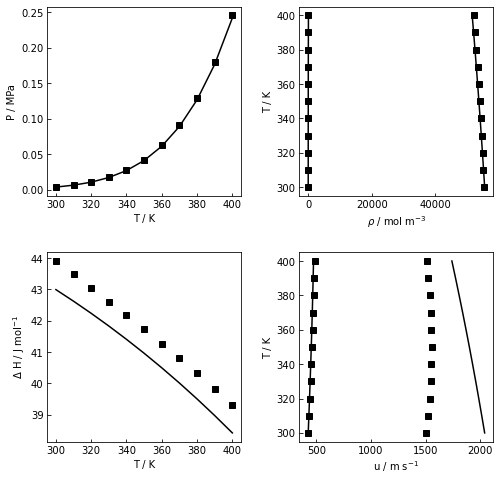

In [16]:
fig = plt.figure(figsize = (8, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax = fig.add_subplot(221)
ax.plot(Tsat, P/1e6, color='k')
ax.plot(Tsat, Psat/1e6, 's', color='k')
ax.set_xlabel('T / K')
ax.set_ylabel('P / MPa')

ax2 = fig.add_subplot(222)
ax2.plot(rhosaftl, Tsat, color='k')
ax2.plot(rhosaftv, Tsat, color='k')
ax2.plot(rhol, Tsat, 's', color='k')
ax2.plot(rhov, Tsat, 's', color='k')
ax2.set_ylabel('T / K')
ax2.set_xlabel(r'$\rho$ / mol m$^{-3}$')

ax3 = fig.add_subplot(223)
ax3.plot(Tsat, dHv/1000, color='k')
ax3.plot(Tsat, Hvap/1000, 's', color='k')
ax3.set_xlabel('T / K')
ax3.set_ylabel(r'$\Delta$ H / J mol$^{-1}$')

ax4 = fig.add_subplot(224)
ax4.plot(ul, Tsat, color='k')
ax4.plot(uv, Tsat, color='k')

ax4.plot(speed_liq, Tsat, 's', color='k')
ax4.plot(speed_vap, Tsat, 's', color='k')

ax4.set_ylabel('T / K')
ax4.set_xlabel(r'u / m s$^{-1}$')

ax.tick_params(direction='in')
ax2.tick_params(direction='in')
ax3.tick_params(direction='in')
ax4.tick_params(direction='in')
# fig.savefig('properties_pure.pdf')

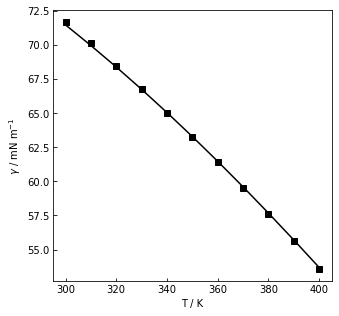

In [17]:
fig = plt.figure(figsize = (5, 5))

ax2 = fig.add_subplot(111)
ax2.plot(Tsat, iftexp, 's', color='k')
ax2.plot(Tsat, ift, color='k')
ax2.set_xlabel('T / K')
ax2.set_ylabel(r'$\gamma$ / mN m$^{-1}$')

ax.tick_params(direction='in')
ax2.tick_params(direction='in')
# fig.savefig('sgt_pure.pdf')

For further information about a method just run: ```eos.method?```